In [28]:
!pip install alibi[tensorflow]

# CF Baseline using library Reference: https://docs.seldon.io/projects/alibi/en/stable/examples/cf_mnist.html


In [36]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.utils import to_categorical

TF version:  2.14.1
Eager execution enabled:  False


In [46]:
input_size = 28 * 28
hidden_size = 128
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = (x_train.astype(np.float32) / 255.0 - 0.1307) / 0.3081
x_test = (x_test.astype(np.float32) / 255.0 - 0.1307) / 0.3081

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

class TF_FeedForwardNN:
    def __init__(self, input_size, hidden_size, num_classes):
        self.model_tf = models.Sequential([
            layers.Flatten(input_shape=(28, 28, 1)),
            layers.Dense(hidden_size, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        self.model_tf.compile(optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
                           loss=losses.CategoricalCrossentropy(from_logits=False),
                           metrics=['accuracy'])

    def train(self, x_train, y_train, epochs, batch_size):
        self.model_tf.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def evaluate(self, x_test, y_test):
        return self.model_tf.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model_tf.predict(x)

model_tf = TF_FeedForwardNN(input_size, hidden_size, num_classes)
model_tf.train(x_train, y_train, num_epochs, batch_size)


evaluation = model_tf.evaluate(x_test, y_test)
print(f'Accuracy on test set: {evaluation[1] * 100:.2f}%')

predictions = model_tf.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_samples = [(x_test[i], true_labels[i], predicted_labels[i]) for i in misclassified_indices]

print(f'Total misclassified samples: {len(misclassified_samples)}')

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.2387 - acc: 0.9269
Epoch 2/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1087 - acc: 0.9675
Epoch 3/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0769 - acc: 0.9765
Epoch 4/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0578 - acc: 0.9817
Epoch 5/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0448 - acc: 0.9854
Epoch 6/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0395 - acc: 0.9875
Epoch 7/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0326 - acc: 0.9889
Epoch 8/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0259 - acc: 0.9917
Epoch 9/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0231 - acc: 0.9921
Epoch 10/10
60000/60000 [==============================] - 

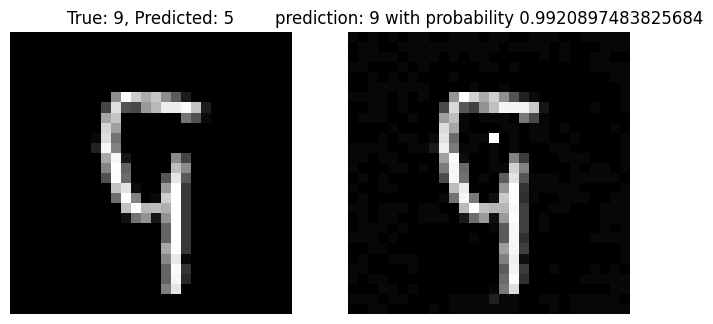

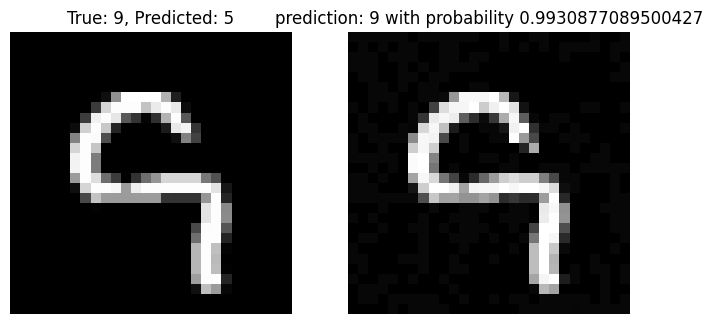

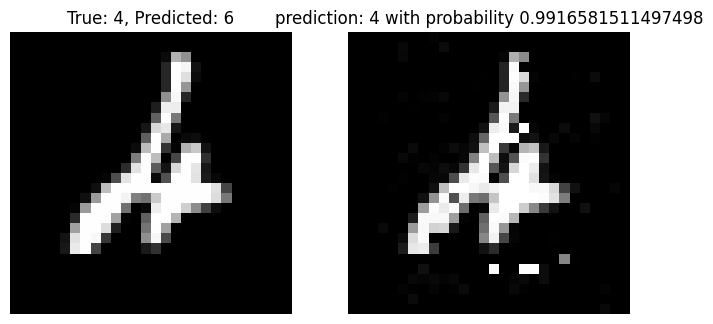

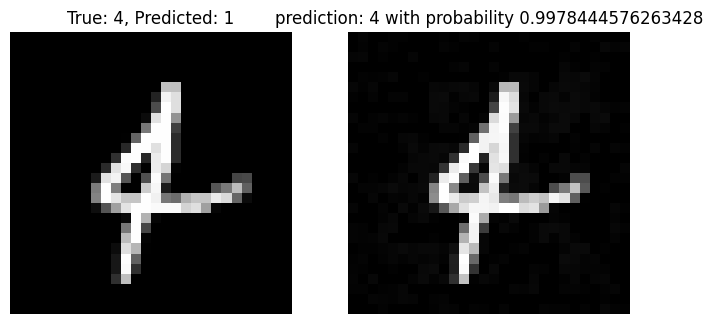

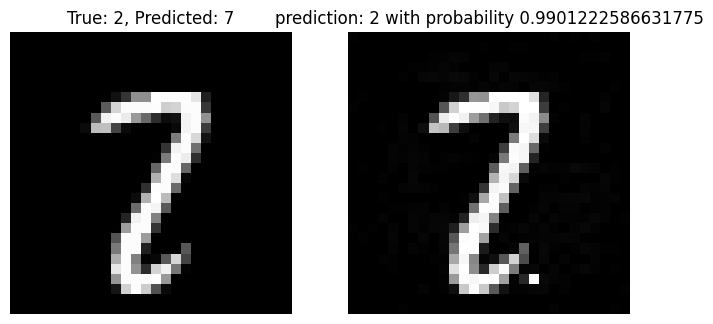

In [51]:
for iteration in range(5):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    image, true_label, predicted_label = misclassified_samples[iteration]
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[0].axis('off')
    shape = (1,) + x_train.shape[1:]
    target_proba = 1.0
    tol = 0.01
    target_class = true_label
    max_iter = 1000
    lam_init = 0.1
    max_lam_steps = 10
    learning_rate_init = 0.1
    feature_range = (x_train.min(), x_train.max())
    
    cf = Counterfactual(model_tf.predict, shape=shape, target_proba=target_proba, tol=tol,
                        target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                        max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                        feature_range=feature_range)
    
    explanation = cf.explain(image.reshape(1, 28, 28, 1))
    pred_class = explanation.cf['class']
    proba = explanation.cf['proba'][0][pred_class]
    
    # print(f'Counterfactual prediction: {pred_class} with probability {proba}')
    axes[1].imshow(explanation.cf['X'].reshape(28, 28), cmap='gray')
    axes[1].set_title(f'prediction: {pred_class} with probability {proba}')
    axes[1].axis('off')
    plt.show()